In [54]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la

In [55]:
# --- global variables --- #

hbar = .658 # eV fs
c = 299.792 # nm fs{-1}

m0 = 5109980 # eV -> this is wrong there's an extra zero that should not be here
mu = .108 * m0 # eV

veps0 = 55.26 # e{2} eV{-1} mum{-1}
vepsS = 3.32 # dimless
vepsW = 6.10 # dimless

Lwell = 0.636 # nm
r0 = Lwell * (vepsW/(2*vepsS)) # nm

A = 1000/(8*(np.pi**2)*veps0*vepsS) # eV nm

''' hbar = .658 # eV fs
#c = 299.792 # nm fs{-1}

m0 = 5.6856800 # eV -> this is wrong there's an extra zero that should not be here
mu = .108 * m0 # eV

veps0 = 5.52638e-2 # e{2} eV{-1} mum{-1}
vepsS = 3.32 # dimless
vepsW = 6.10 # dimless

Lwell = 0.636 # nm
r0 = Lwell * (vepsW/(2*vepsS)) # nm

A = Lwell**2 # eV nm'''


" hbar = .658 # eV fs\n#c = 299.792 # nm fs{-1}\n\nm0 = 5.6856800 # eV -> this is wrong there's an extra zero that should not be here\nmu = .108 * m0 # eV\n\nveps0 = 5.52638e-2 # e{2} eV{-1} mum{-1}\nvepsS = 3.32 # dimless\nvepsW = 6.10 # dimless\n\nLwell = 0.636 # nm\nr0 = Lwell * (vepsW/(2*vepsS)) # nm\n\nA = Lwell**2 # eV nm"

In [56]:
# --- simulation parameters --- #

k_max = .75
N = 500
dk = k_max/N

k_vals = np.linspace(dk, k_max, N)

th_max = 2*np.pi
Th = 300
dth = th_max/Th

cos_vals = np.cos(np.linspace(dth, th_max, Th))

In [57]:
def RytovaKeldysh(ki, kj): # Riemann sum over thetas

    if ki == kj:
        q = np.sqrt(ki**2 + kj**2 - 2*ki*kj*cos_vals[:-1]) # to deal with discontinuity just ignore cos(theta) = 1
    else:
        q = np.sqrt(ki**2 + kj**2 - 2*ki*kj*cos_vals)

    Vl = 1/(q * (1 + r0*q))
    V = np.sum(Vl)

    return V * dth * A
    #return .001735 * V

In [58]:
def Coulomb(): # Riemann sum of the kj components

    V = np.zeros((N, N))

    for i in range(N):
        for j in range(N):
               
            V[i][j] = dk * k_vals[j] * RytovaKeldysh(k_vals[i], k_vals[j])

    return V

In [59]:
def WannierMatrix(): # construction of the Wannier matrix

    K = np.diag( (c**2 * hbar**2 * k_vals**2)/(2 * mu) )
    #K = np.diag( (hbar**2 * k_vals**2)/(2 * mu) ) # eV
    #K = np.diag( 0.3524143287 * k_vals**2 ) # eV

    H = K - Coulomb()

    np.savetxt("Hamiltonian.txt", H, fmt="%.10f")
    np.savetxt("Kinetic.txt", K, fmt="%.10f")
    np.savetxt("Coulomb.txt", Coulomb(), fmt="%.10f")

    return H

In [60]:
eigenvalues, eigenvectors = np.linalg.eig(WannierMatrix())
eigenvalues_SCP, eigenvectors_SCP = la.eig(WannierMatrix())

In [61]:
def EigenvectorsNorm(eigvec):

    Nv = np.zeros((N,N))

    # Similar to josh's
    for i in range(N):
        norm = 0
        for j in range(N):
            norm += 1/(2*np.pi)*k_vals[j]*dk*(np.absolute(eigvec[j,i])**2) # calculate the integral on kj over |eigenfunction(ki,kj)|^2 considering the constants

        for j in range(N):
            Nv[j,i] = eigvec[j,i] / np.sqrt(norm) # divide each of the eigenfunctions by the required constant norm to get it over one'''
    

    '''for i in range(N):
        norm = 0
        for j in range(N):
            norm += 1/(2*np.pi)*k_vals[i]*dk*(np.abs(eigvec[i][j])**2) # calculate the integral on kj over |eigenfunction(ki,kj)|^2 considering the constants

        for j in range(N):
            Nv[i][j] = eigvec[i][j] / np.sqrt(norm) # divide each of the eigenfunctions by the required constant norm to get it over one '''

    np.savetxt('NVectors.txt', Nv, fmt="%.10f")

    return Nv

        

In [62]:
norm_eigenvectors = EigenvectorsNorm(eigenvectors_SCP)

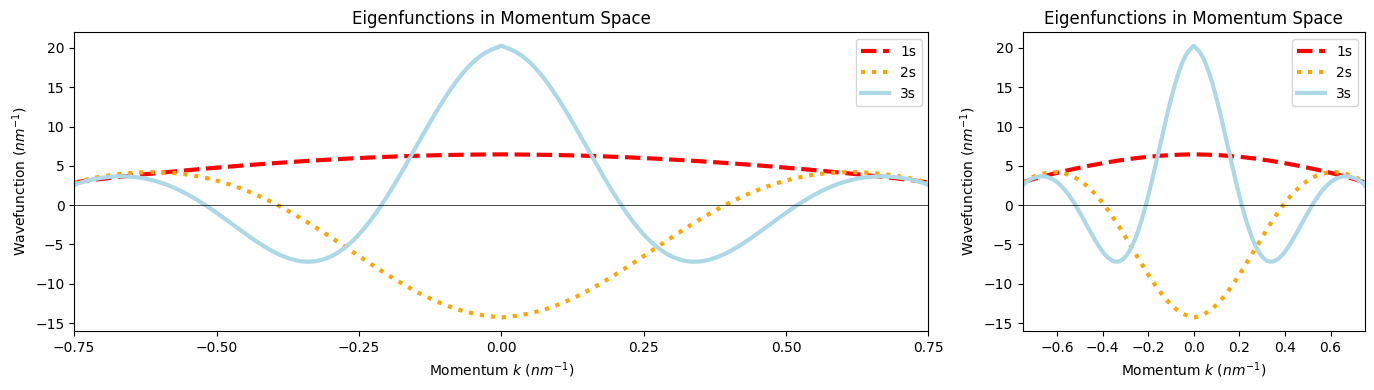

In [63]:
plot_x = np.concatenate((np.flip((-1) * k_vals), k_vals))

fig, axes = plt.subplots(1, 2, figsize=(14, 4), gridspec_kw={'width_ratios': [10, 4]})

# --- numpy eigenvalues function --- #

axes[0].plot(plot_x, np.concatenate((np.flip(norm_eigenvectors[:, 0]), norm_eigenvectors[:, 0])), label=f'1s', c='red', linewidth=3, linestyle='--')
axes[0].plot(plot_x, np.concatenate((np.flip(norm_eigenvectors[:, 1]), norm_eigenvectors[:, 1])), label=f'2s', c='orange', linewidth=3, linestyle=':')
axes[0].plot(plot_x, np.concatenate((np.flip(norm_eigenvectors[:, 2]), norm_eigenvectors[:, 2])), label=f'3s', c='lightblue', linewidth=3)
axes[0].plot(plot_x, np.zeros(len(plot_x)), c='black', linewidth=0.5)
axes[0].set_xticks([-0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75])
''' axes[0].plot(plot_x, np.concatenate((np.flip(eigenvectors[:, 3]), eigenvectors[:, 3])), label=f'4s', linewidth=3, linestyle='--')
axes[0].plot(plot_x, np.concatenate((np.flip(eigenvectors[:, 4]), eigenvectors[:, 4])), label=f'5s', linewidth=3, linestyle=':')
axes[0].plot(plot_x, np.concatenate((np.flip(eigenvectors[:, 5]), eigenvectors[:, 5])), label=f'6s', linewidth=3)
axes[0].plot(plot_x, np.concatenate((np.flip(eigenvectors[:, 6]), eigenvectors[:, 8])), label=f'7s', linewidth=3, linestyle='--')
axes[0].plot(plot_x, np.concatenate((np.flip(eigenvectors[:, 7]), eigenvectors[:, 7])), label=f'8s', linewidth=3, linestyle=':')
axes[0].plot(plot_x, np.concatenate((np.flip(eigenvectors[:, 8]), eigenvectors[:, 8])), label=f'9s', linewidth=3) '''


axes[0].set_xlabel('Momentum $k$ $(nm^{-1})$')
axes[0].set_xlim(-.75, .75)

#axes[0].set_ylim(-20, 70)
axes[0].set_ylabel('Wavefunction $(nm^{-1})$')
axes[0].set_title('Eigenfunctions in Momentum Space')
axes[0].legend(loc='upper right')

axes[1].plot(plot_x, np.concatenate((np.flip(norm_eigenvectors[:, 0]), norm_eigenvectors[:, 0])), label=f'1s', c='red', linewidth=3, linestyle='--')
axes[1].plot(plot_x, np.concatenate((np.flip(norm_eigenvectors[:, 1]), norm_eigenvectors[:, 1])), label=f'2s', c='orange', linewidth=3, linestyle=':')
axes[1].plot(plot_x, np.concatenate((np.flip(norm_eigenvectors[:, 2]), norm_eigenvectors[:, 2])), label=f'3s', c='lightblue', linewidth=3)
axes[1].plot(plot_x, np.zeros(len(plot_x)), c='black', linewidth=0.5)

axes[1].set_xlabel('Momentum $k$ $(nm^{-1})$')
axes[1].set_xlim(-.75, .75)
#axes[1].set_ylim(-20, 75)
axes[1].set_ylabel('Wavefunction $(nm^{-1})$')
axes[1].set_title('Eigenfunctions in Momentum Space')
axes[1].legend()

plt.tight_layout()
plt.show()

/Users/pedrobraga/Documents/Cambridge/wa_two/wa_two_env/lib/python3.13/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/pedrobraga/Documents/Cambridge/wa_two/wa_two_env/lib/python3.13/site-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


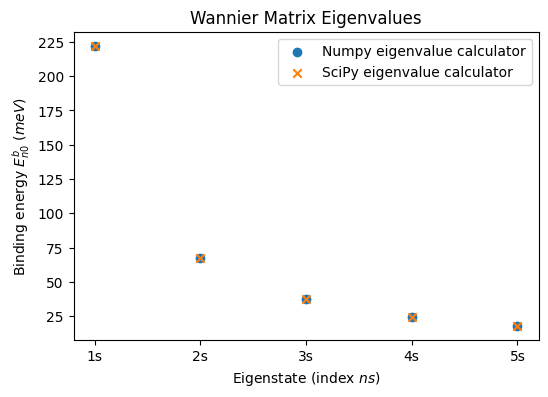

In [64]:
plt.figure(figsize=(6,4))
plt.scatter(['1s', '2s' , '3s' , '4s', '5s'], (-1000)* eigenvalues[:5], label='Numpy eigenvalue calculator')
plt.scatter(['1s', '2s' , '3s' , '4s', '5s'], (-1000)* eigenvalues_SCP[:5], label='SciPy eigenvalue calculator', marker='x')
plt.xlabel('Eigenstate (index $ns$)')
plt.ylabel('Binding energy $E_{n0}^b$ $(meV)$')
plt.title('Wannier Matrix Eigenvalues')
plt.legend()
plt.show()